## Run a script which pulls about 7364 unique english language captions and their tfidf vectors from the MySQL databank and brings into scope the variables we need, a sparse matrix and also a matching dataframe with the names of the videos.

In [1]:
%%time
%run prepare_variables.py

CPU times: user 9.26 s, sys: 384 ms, total: 9.64 s
Wall time: 9.76 s


In [3]:
p.shape

(7364, 429429)

In [4]:
p

<7364x429429 sparse matrix of type '<class 'numpy.float64'>'
	with 1581374 stored elements in COOrdinate format>

#### That is very sparse - only 0.05% of the matrix has anything in it.

## Run KMeans to find ten clusters among the sparse vectors

In [48]:
%%time
from numpy.random import random 
from scipy.sparse import * 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10).fit(p) 

CPU times: user 4min 52s, sys: 3.16 s, total: 4min 55s
Wall time: 4min 55s


## Try to find an indication of how many clusters there actually should be

In [20]:
%%time
nclusters_inertias = []
for i in range(3,21):
    kmeans = KMeans(n_clusters=i).fit(p)
    ni = (i,kmeans.inertia_)
    nclusters_inertias.append(ni)

CPU times: user 1h 37min 19s, sys: 54.4 s, total: 1h 38min 14s
Wall time: 1h 38min 11s


In [21]:
nclusters_inertias

[(3, 6456.061284711146),
 (4, 6358.863941936795),
 (5, 6296.709640187096),
 (6, 6241.446150488019),
 (7, 6196.26437697837),
 (8, 6162.17817194212),
 (9, 6127.886844432714),
 (10, 6095.412823592397),
 (11, 6065.050909499994),
 (12, 6036.800028621531),
 (13, 6017.912065518555),
 (14, 5999.1795286251045),
 (15, 5984.151619949354),
 (16, 5961.347248249794),
 (17, 5954.976305773513),
 (18, 5929.155920968223),
 (19, 5912.985642937897),
 (20, 5907.364906985606)]

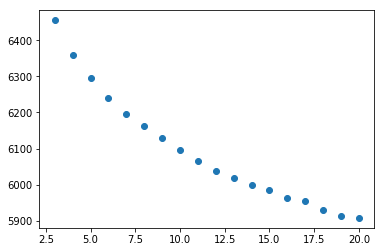

In [26]:
import matplotlib.pyplot as plt       # https://stackoverflow.com/questions/18458734/python-plot-list-of-tuples
%matplotlib inline
plt.scatter(*zip(*nclusters_inertias))
plt.show()

#### ...oops that approach was an oversimplification : 

> increasing k without penalty will always reduce the amount of error in the resulting clustering, to the extreme case of zero error if each data point is considered its own cluster (i.e., when k equals the number of data points, n)

https://en.wikipedia.org/wiki/Determining_the_number_of_clusters_in_a_data_set

**without penalty** Good to know that I was about to try running it overnight to a cluster of 40 rather than 20 which still would not have found anything. Will have to implement one of the techniques discussed in the article.

## How many videos has it found in each cluster?

In [49]:
videos_df['cluster_labels'] = kmeans.labels_
videos_df.groupby('cluster_labels').count()[['videoTitle']]

,videoTitle
cluster_labels,
0,548
1,1855
2,1035
3,850
4,154
5,420
6,277
7,287
8,1213


## Sample ten videos randomly from each of those groups:

In [53]:
pd.set_option('display.max_rows', 120)

# https://stackoverflow.com/questions/22472213/python-random-selection-per-group

size = 10        # sample size
replace = False  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
clustered_sample = videos_df.groupby('cluster_labels', as_index=False).apply(fn)
clustered_sample[['videoTitle','cluster_labels', 'link']]

videoTitle  cluster_labels  \
0 2436                 CSV Data 1 - Intro to Data Science               0   
  3562  Les serveurs dédiés OVH.com au cœur de l’infra...               0   
  6780                      All About Data Scientist Jobs               0   
  3798  What Data Is Good For Linear Regression - Intr...               0   
  4555                 End-to-end Data Science with Civis               0   
  1024  Making data mean more through storytelling | B...               0   
  4752  Data Science Essentials | Microsoft on edX | C...               0   
  5875  Cornering the Market: Predicting the Price of ...               0   
  7155           What is Data Science? [Data Science 101]               0   
  5519  Data Wrangling, Normalization & Preprocessing:...               0   
1 993                           Phoebe loves doing tricks               1   
  6363  Canadian School Teacher Suspended After Giving...               1   
  5758    Scenarios for MapReduce - Intro to Data Science               1   
  1494  FutureGrid MOOC: IPOP Unit 10: IPOP Applicatio...               1   
  234   Topcoder Data Science Marathon Match: Prostate...               1   
  4974  Cats removed from filthy conditions in Barnste...               1   
  3422            Grandma is not Cooking for Thanksgiving               1   
  4300  Incredible Girl Cooking Water Snake Soup | How...               1   
  5961  किचन टिप्स, Kitchen Tips and Tricks in Hindi -...               1   
  6098        Normal Distribution - Intro to Data Science               1   
2 1367            Rooftop Cooking: The 'Turfuffle Burger'               2   
  7047  Holiday Cooking Challenge: Full Meal Under 5 M...               2   
  6316  Catch n Cook over night fishing trip Andy's Fi...               2   
  7056  Quick Trip to San Francisco and Marin County |...               2   
  173                        Train a text embedding model               2   
  4739             Personal Trainers Taste Test Junk Food               2   
  3617             How to slice an onion with Francis Lam               2   
  1087              Paul Gauguin's cooking lesson (+subs)               2   
  34          Game Tree - Georgia Tech - Machine Learning               2   
  2619    Part I: Vermont gubernatorial candidates debate               2   
3 782   8.3.1 Principal Component Analysis Problem For...               3   
  2282  Using Exponential Functions To Model Data Chap...               3   
  494   1.2.3 Linear Regression with One Variable - Co...               3   
  2868        Basics of MapReduce - Intro to Data Science               3   
  3673         Plotting in Python - Intro to Data Science               3   
  7217  Installing bCNC on Windows 10 64bit (Python 2....               3   
  1982          Learning Classifier Systems in a Nutshell               3   
  3585           [15][1]From PCA to autoencoders (5 mins)               3   
  2211  Machine Learning A Cappella - Overfitting Thri...               3   
  6216            Unit 2 - Anaconda / Screencast tutorial               3   
4 3423                        TruEat: Cooking With Family               4   
  2478  Armenian Sweet Bread Bagharj - Բաղարջ - Heghin...               4   
  5620  Simple Vanilla Cupcakes - Vanilla Muffins by *...               4   
  4269  ✅Carrot Pickle Recipe- Tasty Gajar-ka-achar by...               4   
  4721  Peeled Wheat Pilaf with Mushrooms Recipe - Heg...               4   
  4596  Healthy Cooking Recipes - The Perfect Way To C...               4   
  4132  How to make #Marble Cake||Tutorial||Cooking wi...               4   
  7178  Discover Method for Cooking Healthy Pork Ribs ...               4   
  1996  Cooking with the versatile corned beef: Reuben...               4   
  5299                BBQ MEATBALLS || Cooking with Carly               4   
5 2267                 BADAM KA SHARBAT *COOK WITH FAIZA*               5   
  572                                   Smo